In [1]:
import os
import sys
import torch
import visdom
import argparse
import numpy as np
import torch.nn as nn
import scipy.misc as misc
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
import torch.nn.functional as F
from tqdm import tqdm


from skimage.color import label2rgb
from skimage import measure
from skimage import morphology
import matplotlib.pyplot as plt


from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.metrics import scores

import pydensecrf.densecrf as dcrf


import imageutl as imutl
import visualizationutl as view
import netutility as  netutl


In [2]:
PATH = 'db'
PATHMODEL = '.'
NAMEDATASET = 'train'
NAMEMODEL = 'unet_cars_1_68.pkl'
pathnamedataset = os.path.join(PATH, NAMEDATASET)
pathnamemodel = os.path.join(PATHMODEL, NAMEMODEL)

print(pathnamedataset)
print(pathnamemodel)

db/train
./unet_cars_1_68.pkl


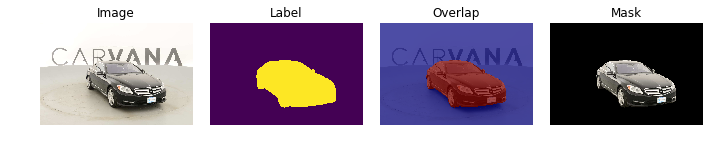

In [3]:
# show dataset
data = imutl.dataProvide( pathnamedataset, ext='jpg', fn_image='image', fn_label='label', lext='gif')
view.display_image_and_gt(data)

In [4]:
# Setup Model
model = torch.load(pathnamemodel)
model.eval()

unet (
  (down1): unetDown (
    (conv): unetConv2 (
      (conv1): Sequential (
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU ()
      )
      (conv2): Sequential (
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU ()
      )
    )
    (down): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (down2): unetDown (
    (conv): unetConv2 (
      (conv1): Sequential (
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU ()
      )
      (conv2): Sequential (
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU ()
      )
    )
    (down): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1

(572, 572, 3)


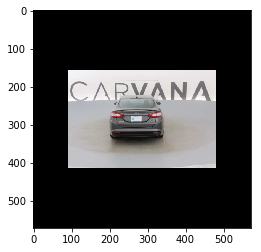

In [5]:
# select image dataset
image_org = data.getimage( np.random.randint( data.num ) )
image_in, asp, image_in_oz = netutl.unet_transform_image_size(image_org, size=388)

print(image_in.shape)
plt.imshow(image_in)
plt.show()


In [6]:
# fordward torch net

image_proc = image_in[:, :, ::-1]
image_proc = image_proc.astype(float)
# NHWC -> NCHW
image_proc = image_proc.transpose(2, 0, 1)
image_proc = image_proc[np.newaxis,...]
image_proc = torch.from_numpy(image_proc).float()

if torch.cuda.is_available():
    model.cuda(0)
    images_torch = Variable(image_proc.cuda(0), volatile=True )
else:
    images_torch = Variable(image_proc)

outputs = model(images_torch)

print('ok!!!' )


ok!!!


(388, 388)


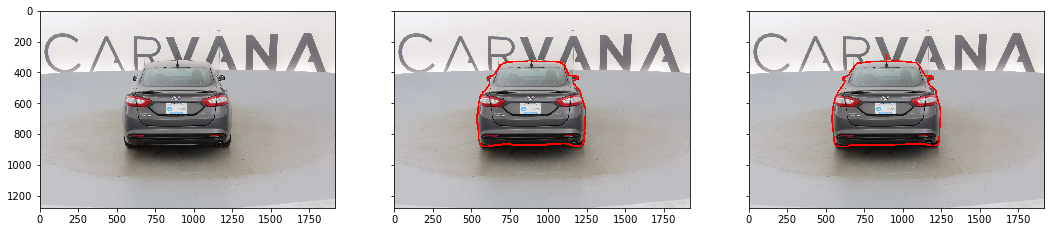

(1280, 1918)
(1280, 1918)
0.6673618352450469
0.6673618352450469
0.6673618352450469


In [7]:

pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
print( pred.shape )

label_org = data.getlabel()
label_hat = netutl.inv_transform_image_size(pred, label_org.shape, asp)

#plt.imshow(label_hat)
#plt.show()
#print( np.min(pred), np.max(pred) )

fig, ax = plt.subplots(1, 3, figsize=(18, 18), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(image_org)
ax[1].imshow(netutl.drawsegcontour(image_org,label_hat, line_width = 10))
ax[2].imshow(netutl.drawsegcontour(image_org,(label_org/255).astype(np.uint8), line_width=10 ))
plt.show()


print(label_hat.shape)
print(label_org.shape)
print(float(label_hat.shape[0])/label_hat.shape[1])
print(float(image_org.shape[0])/image_org.shape[1])
print(asp)



(1280, 1918)


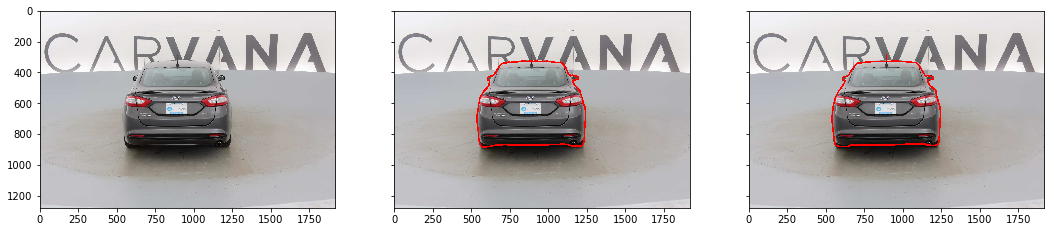

(1280, 1918)
(1280, 1918)
0.6673618352450469
0.6673618352450469
0.6673618352450469


In [8]:
#image_proc = (np.array(image_in_oz)*255).astype('uint8')

pred = np.array(F.softmax(outputs).data.cpu().numpy())

pred_1 =netutl.inv_transform_label_size(pred[0,0,:,:],label_org.shape, asp)
pred_2 =netutl.inv_transform_label_size(pred[0,1,:,:],label_org.shape, asp)
pred=np.concatenate((pred_1[np.newaxis,np.newaxis,:,:],pred_2[np.newaxis,np.newaxis,:,:]),axis=1).astype('float32')

label_hat_p = netutl.crf(image_org, pred)
#label_hat_p = netutl.inv_transform_image_size(label_hat_p, label_org.shape, asp)
print(label_hat_p.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 18), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(image_org)
ax[1].imshow(netutl.drawsegcontour(image_org,label_hat_p, line_width = 10))
ax[2].imshow(netutl.drawsegcontour(image_org,(label_org/255).astype(np.uint8), line_width=10 ))
plt.show()

print(label_hat.shape)
print(label_org.shape)
print(float(label_hat.shape[0])/label_hat.shape[1])
print(float(image_org.shape[0])/image_org.shape[1])
print(asp)



In [9]:
#label_org = (label_org/255).astype(np.uint8)

print('Metric:')
print( netutl.dicecoef((label_org/255).astype(np.uint8), label_hat))
print( netutl.dicecoef((label_org/255).astype(np.uint8), label_hat_p))

Metric:
0.993288241641
0.994546918143
